In [1]:
!pip install git+https://github.com/Shafi2016/pymodeltime.git


  Cloning https://github.com/Shafi2016/pymodeltime.git to /tmp/pip-req-build-krc9p00d
  Running command git clone --filter=blob:none --quiet https://github.com/Shafi2016/pymodeltime.git /tmp/pip-req-build-krc9p00d
  Resolved https://github.com/Shafi2016/pymodeltime.git to commit 9dc659d6a6343fb1ef285cc9ab1453791615116d
  Preparing metadata (setup.py) ... done


In [14]:
from pymodeltime import ArimaReg, ProphetReg
from pymodeltime import ModelTimeTable, ModelTimeAccuracy, ModelTimeCalibration, ModelTimeForecast,ModelTimeRefit
from pymodeltime import ArimaReg, ProphetReg
from pymodeltime import MLModelWrapper,H2OAutoMLWrapper
from pymodeltime import plot_modeltime_forecast
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import logging

# Set logging level to WARNING to suppress DEBUG and INFO messages
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)


In [3]:
import requests
import pandas as pd

url = 'https://raw.githubusercontent.com/Shafi2016/pymodeltime/main/data/m750.csv'

response = requests.get(url)
open('m750.csv', 'wb').write(response.content)

data = pd.read_csv('m750.csv')

print(data.head(3))


     id        date  value
0  M750  1990-05-01   6620
1  M750  1990-06-01   6690
2  M750  1990-07-01   6000


In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

In [18]:
# Initialize and fit the ARIMA model
arima_reg_model_uni = ArimaReg(
    non_seasonal_ar=1,
    non_seasonal_differences=0,
    non_seasonal_ma=1,
    seasonal_ar=0,
    seasonal_differences=1,
    seasonal_ma=1,
    seasonal_period=12,trend= 't',uses_date=True
) # (no trend), 'c' (constant), 't' (linear trend), or 'ct' (constant and linear trend).

prophet_model_uni  = ProphetReg(seasonality_yearly=True, seasonality_weekly=True,
                               seasonality_daily=False, changepoint_range=0.5, prior_scale_seasonality=5.0,
                               season='multiplicative',interval_width=0.95 )


arima_reg_model_uni.fit(train_data[['value']], target_column='value')
prophet_model_uni.fit(train_data[['date', 'value']], target_column='value', date_column='date')




# ModelTimeTable

In [6]:
modeltime_table_uni = ModelTimeTable(arima_reg_model_uni,prophet_model_uni)

# ModelTimeCalibration

In [7]:
# Example usage univariate
test_data_uni = test_data[['date','value']]
test_data_uni.dropna(inplace=True)

model_time_calibrator_uni = ModelTimeCalibration(modeltime_table_uni, test_data_uni,target_column = 'value')
model_time_calibrator_uni.calibrate()

calibration_results_df_uni = model_time_calibrator_uni.get_calibration_results()
print(calibration_results_df_uni)




   .model_id    .model              .model_desc   .type  .calibration_data
0          1  <fit[+]>  ARIMA(1,0,1)(0,1,1)[12]  Custom  <tibble [61 × 4]>
1          2  <fit[+]>                  PROPHET  Custom  <tibble [61 × 4]>


# ModelTimeAccuracy

In [8]:
# Example usage


target_column = 'value'  # Replace with your actual target column name
modeltime_accuracy = ModelTimeAccuracy(modeltime_table_uni, test_data_uni, target_column)
accuracy_results = modeltime_accuracy.calculate_accuracy()
print(accuracy_results)

   model_id               model_desc        mae        rmse        r2
0         1  ARIMA(1,0,1)(0,1,1)[12]  572.06390  612.691075 -0.024123
1         2                  PROPHET  203.88089  275.135310  0.793480


# ModelTimeForecast

In [9]:
forecast_test_uni = ModelTimeForecast(modeltime_table_uni, new_data=test_data_uni, actual_data=data,target_column= 'value')
forecast_results_test_uni = forecast_test_uni.forecast()
forecast_results_test_uni.to_csv("forecast_results_uni.csv", index=False)

Processing predictions for model: ArimaReg
Processing predictions for model: ProphetReg
Original columns before processing for Prophet: Index(['date', 'value'], dtype='object')
Columns after processing for Prophet: Index(['ds', 'value'], dtype='object')


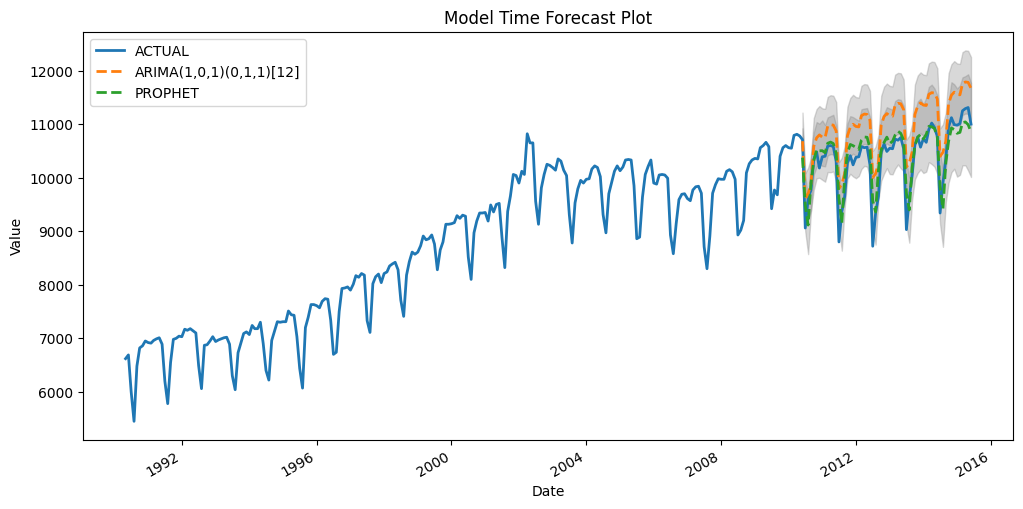

In [10]:

plot_modeltime_forecast(forecast_results_test_uni, interactive=False)  # For static plot
plot_modeltime_forecast(forecast_results_test_uni, interactive=True)   # For interactive plot

# ModelTimeRefit

In [15]:

# Initialize the refitter
refitter = ModelTimeRefit(modeltime_table_uni, verbose=True, parallel=True, max_workers=4)

# Refit the models with the new data
full_data = pd.concat([train_data, test_data], ignore_index=True)  # Replace with your entire dataset (train + test)


target_column = 'value'  # Specify the target column from your dataset
refitted_models = refitter.refit_models(full_data, target_column)


Model successfully refitted: <pymodeltime.ProphetReg.ProphetReg object at 0x7866040cb7c0>
Model successfully refitted: <pymodeltime.ArimaReg.ArimaReg object at 0x7865c3af5c90>


In [16]:
forecast_horizon = "12 months"

forecast_future = ModelTimeForecast(modeltime_table_uni, actual_data= full_data, forecast_horizon=forecast_horizon,target_column= 'value')
forecast_results_future_uni = forecast_future.forecast()
forecast_results_future_uni.to_csv("forecast_results_future_uni.csv", index=False)


Processing future predictions for model: ArimaReg
Original future_data:           ds
0 2015-06-30
1 2015-07-31
2 2015-08-31
3 2015-09-30
4 2015-10-31
Processed future_data for Prophet:           ds
0 2015-06-30
1 2015-07-31
2 2015-08-31
3 2015-09-30
4 2015-10-31


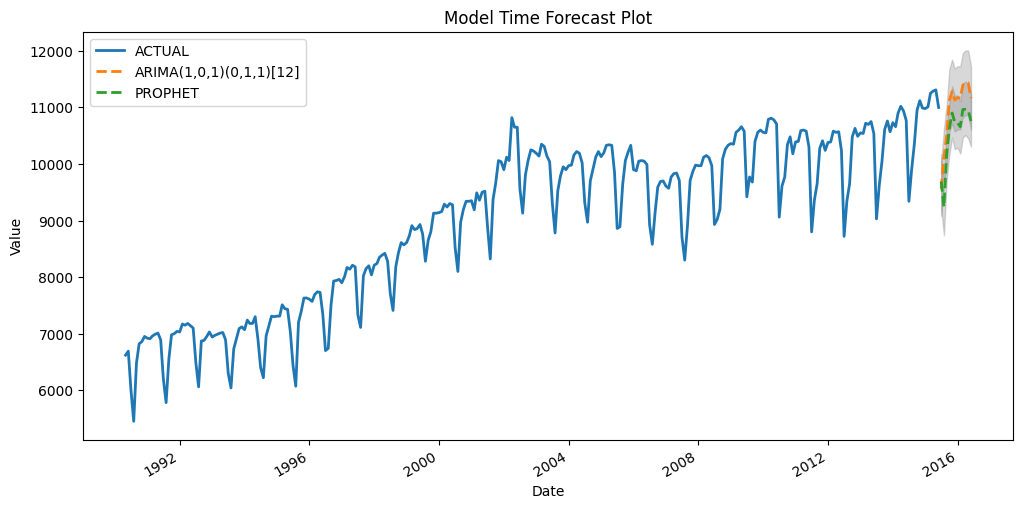

In [17]:

plot_modeltime_forecast(forecast_results_future_uni, interactive=False)  # For static plot
plot_modeltime_forecast(forecast_results_future_uni, interactive=True)   # For interactive plot